In [1]:
import os
import shutil

from IPython.display import display, clear_output
import ipywidgets as widgets

import torch
from torch import nn, optim
from matplotlib import pyplot as plt

from rndshapesdataset import gen_shapes_data, ShapesGenerator

In [2]:
class EncoderBlock(nn.Module):
    @property
    def i(self):
        return self._i
    
    def __init__(self, in_chn, out_chn):
        super().__init__()

        self._i = torch.empty()

        self._encoder = nn.Sequential(
            nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_chn),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True),
        )

    def forward(self, X):
        Y, self._i = self._encoder(X)
        return Y


class DecoderBlock(nn.Module):
    def __init__(self, in_chn, out_chn, eBlock: "EncoderBlock"):
        super().__init__()

        self._eBlock = eBlock

        self._decoder = nn.Sequential(
            nn.ConvTranspose2d(in_chn, out_chn, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(out_chn),
            nn.ReLU(),
        )
        self._unPool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, X):
        Y = self._decoder(X)
        Y = self._unPool(Y, self._eBlock.i)
        return Y

In [3]:
class AutoEncoderDecoder(nn.Module):
    def __init__(self, in_chn: int, encode_bits: int):
        super().__init__()

        self._encoder = nn.Sequential(
            nn.Conv2d(in_chn, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Flatten(),
            nn.Linear(128 * 8 * 8, encode_bits),
            nn.Softmax(dim=1),
        )

        self._decoder = nn.Sequential(
            nn.Linear(encode_bits, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, in_chn, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(in_chn),
            nn.Sigmoid(),
        )

    def forward(self, X):
        encoded = self._encoder(X)
        decoded = self._decoder(encoded)
        return decoded

In [2]:
dg = ShapesGenerator(64, 64)
colors = ["red", "green", "blue", "yellow", "black"]
shapes = ["circle", "triangle", "square", "pentagon"]
sizes = ["very#small", "small", "medium", "large", "very#large"]

def gen_clicked(_):
    with output:
        clear_output()
        gen_shapes_data(dg, shapes, colors, sizes)
        print("Generated")

def clear_clicked(_):
    with output: 
        clear_output()
        shutil.rmtree(dg.DIR)
        print("Data Cleared")
    os.mkdir(dg.DIR)

gen_button = widgets.Button(description='Generate DataSet')   
gen_button.on_click(gen_clicked)
clear_button = widgets.Button(description='Clear DataSet')
clear_button.on_click(clear_clicked)
output = widgets.Output()
display(gen_button, clear_button, output)

Button(description='Generate DataSet', style=ButtonStyle())

Button(description='Clear DataSet', style=ButtonStyle())

Output()

In [7]:
model = AutoEncoderDecoder(3, 32)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

In [8]:
for epoch in range(10):
    los = 0
    i = 0
    data = dg.data(mb=1)
    for b in data:
        optimizer.zero_grad()
        out = model(b)
        loss = loss_fn(out, b)
        loss.backward()
        optimizer.step()
        los += loss.item()
        i += 1
    print(f"Epoch {epoch}: {los / i}")

Epoch 0: 0.22356107093320035
Epoch 1: 0.19620144249189017
Epoch 2: 0.16928692840703644
Epoch 3: 0.14910510064351676
Epoch 4: 0.13590662550218036
Epoch 5: 0.12571179903674834
Epoch 6: 0.11766570054068423
Epoch 7: 0.11040515006326213
Epoch 8: 0.10430505056634988
Epoch 9: 0.09889159325768451
Epoch 10: 0.09250421379462327
Epoch 11: 0.08875697249970814
Epoch 12: 0.08297273704763686
Epoch 13: 0.07914472706984765
Epoch 14: 0.07698092687100468
Epoch 15: 0.07384007278424089
Epoch 16: 0.07054423515011768
Epoch 17: 0.06846337180842857
Epoch 18: 0.06606143194776361
Epoch 19: 0.06319860298887338
Epoch 20: 0.060702160000801086
Epoch 21: 0.0588191218747951
Epoch 22: 0.056186838389033135
Epoch 23: 0.05528694003967956
Epoch 24: 0.05368649771455491
Epoch 25: 0.05190805035947573
Epoch 26: 0.05056823823269051
Epoch 27: 0.048118999633606115
Epoch 28: 0.047334718103013415
Epoch 29: 0.046467687575017465
Epoch 30: 0.04514420001149768
Epoch 31: 0.04348098750382957
Epoch 32: 0.042243066308374454
Epoch 33: 0.041

In [23]:
data = dg.data()

def next_clicked(_):
    im = next(data)
    with output:
        clear_output()
        out = model(im)
        plt.imshow(out.squeeze().detach().numpy().transpose(1, 2, 0))
        plt.show()

next_button = widgets.Button(description="Next")
next_button.on_click(next_clicked)
output = widgets.Output()
display(next_button, output)

Button(description='Next', style=ButtonStyle())

Output()

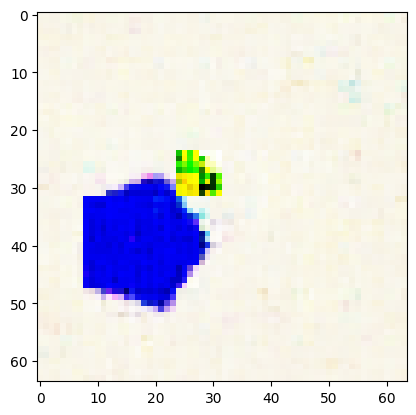

In [25]:
im = next(data)
out = model(im)
plt.imshow(out.squeeze().detach().numpy().transpose(1, 2, 0))
plt.show()